# Milestone 3

### AI agent capable of generating KPIs and dashboards/reports based on user inputs. 

In [180]:
pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain transformers faiss-cpu networkx huggingface-hub pandas tabulate matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import HuggingFacePipeline, GPT4All, HuggingFaceHub
from langchain.chains import LLMChain, RetrievalQA
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain.docstore import InMemoryDocstore
from langchain.docstore.document import Document
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from flask import Flask, request, jsonify
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline
import faiss
import numpy as np
import re
import networkx as nx
import torch
import logging
from datetime import datetime
import json
from fpdf import FPDF
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import requests
import os
import threading
import time

## Knowledge Base Parsing and Graph Construction

In this section, the agent receives the knowledge base (for now, just a mock) in JSON format and transforms it into a structured graph. The JSON is parsed to extract nodes and relationships, thereby constructing a directed graph that represents the knowledge structure. This graph can then be used for reasoning and inference, facilitating the analysis of relationships between concepts.

Knowledge Base (KB) Graph Structure

- **Nodes**:
  - **Machine Nodes**: Represent machines.
  - **KPI Nodes**: Represents KPIs.

- **Edges**:
  - **Machine-KPI Relationships**: Each machine node is linked to one or more KPI nodes. 

In [ ]:
def build_graph_from_json(json_file_path):
    # Crea un grafo vuoto
    G = nx.DiGraph()

    # Leggi il file JSON
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Aggiungi i nodi macchina
    for machine in data.get("machines", []):
        G.add_node(
            machine["id"],
            node_type="Machine",
            name=machine["name"],
            production_line=machine["productionLine"],
            factory=machine["factory"],
            machine_type=machine["machineType"]
        )

    # Aggiungi i nodi KPI
    for kpi in data.get("kpis", []):
        G.add_node(
            kpi["nameID"],
            node_type="Base KPI" if kpi.get("formula") is None else "Derived KPI",
            name=kpi["description"],
            category=kpi["category"],
            unit=kpi["unit"],
            relation_number=kpi["relationNumber"],
            formula=kpi.get("formula")
        )

    # Aggiungi le relazioni
    for rel in data.get("relation", []):
        G.add_edge(
            rel["machineID"],
            rel["kpiID"],
            relationship="monitors"
        )

    return G

In [ ]:
KB_PATH = "/app/Milestone2/kb.json"

G = build_graph_from_json(KB_PATH)

For each node, a textual description is created.

In [ ]:
def describe_networkx_graph(G):
    # Dizionario per descrizioni
    descriptions = {}
    
    # Descrivi i nodi delle macchine
    machine_nodes = [node for node, data in G.nodes(data=True) if data.get("node_type") == "Machine"]

    for node in machine_nodes:
        data = G.nodes[node]
        machine_name = data.get("name", "unknown name")
        machine_type = data.get("machine_type", "Unknown type")
        production_line = data.get("production_line", "unknown line")
        factory = data.get("factory", "unknown factory")

        incoming_edges = G.in_edges(node)
        source_nodes = [edge[0] for edge in incoming_edges]
        kpi_names = [G.nodes[source].get('name', '') for source in source_nodes]
        concatenated_kpi_names = ", ".join(kpi_names)
        
        # Genera descrizione per la macchina
        description = f"It is a {machine_type} machine located in {factory} on production line {production_line}."
        
        if kpi_names:
            description += f" It monitors the following KPIs: {concatenated_kpi_names}."
        else:
            description += " It has no KPIs associated with it."

        descriptions[machine_name] = description
    
    # Descrivi i nodi dei KPI
    kpi_nodes = [node for node, data in G.nodes(data=True) if "Base KPI" in data.get("node_type", "") or "Derived KPI" in data.get("node_type", "")]
    
    # Generate descriptions for all nodes
    for node in kpi_nodes:
        data = G.nodes[node]
        kpi_name = data.get('name', 'unknown name')
        category = data.get('category', 'unknown category')
        has_formula = "Derived KPI" in data.get("node_type", "")
        formula = data.get('formula', 'no formula') if has_formula else 'no formula'
        unit = data.get('unit', 'unknown unit')
        
        description = f"It is a KPI in the {category} category. "
        if has_formula:
            description += f"It is a derived KPI and uses the formula: {formula}. "
        else:
            description += "It is a base KPI with no formula."
        
        description += f"The unit of measurement is {unit}."
        descriptions[kpi_name] = description

    return descriptions

## Retrieval

Convert the descriptions in a format suitable for retrieval through Langchain.

In [ ]:
def faiss_generation():
    G = build_graph_from_json(KB_PATH)
    generated_descriptions = describe_networkx_graph(G)
    descriptions = []

    for node, desc in generated_descriptions.items():
        print(f"{node}: {desc}")
        descriptions.append({node: desc})


    # ## Retrieval

    # Convert the descriptions in a format suitable for retrieval through Langchain.

    # Step 1: Convert node descriptions into Langchain Document objects
    documents = []

    # Iterate over the list of dictionaries in `descriptions`
    for item in descriptions:
        for node, desc in item.items():  # Extract the key-value pair from each dictionary
            # Include the node name in the page content to make it explicit
            document_text = f"{node}: {desc}"
            documents.append(Document(page_content=document_text, metadata={"node": node}))

    # Step 2: Generate embeddings for each node description using HuggingFace
    embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
    embeddings = [embedding_model.embed_query(doc.page_content) for doc in documents]

    # Step 3: Create FAISS index and add the embeddings
    dimension = len(embeddings[0])
    faiss_index = faiss.IndexFlatL2(dimension)
    faiss_index.add(np.array(embeddings))

    # Step 4: Create `index_to_docstore_id` and a `docstore`
    index_to_docstore_id = {i: str(i) for i in range(len(documents))}
    docstore = InMemoryDocstore(({str(i): doc for i, doc in enumerate(documents)}))

    # Step 5: Create FAISS vector store with HuggingFace embeddings and the node documents
    vector_store = FAISS.from_documents(documents, embedding_model)

    # Salva il vector store
    vector_store.save_local("/app/Milestone3/vector_store")

## Generation

### Steps of elaboration of the user query:

Check if the query can be answered (informational query) or if there is the need to retrieve historical data (action query):
- if the query is informational, the model just answers it based on the provided context
- if the query is action, the model has to extract specific elements to be able to contact the KPI calculation engine.

The elements needed are:
- kpi name
- machine name
- the query dateframe (single date, range of dates, aggregation period)
- operation (optional)

In [189]:
model = ChatOpenAI(
    base_url = 'http://localhost:11434/v1',
    temperature = 0, 
    api_key = 'not-needed',
    model_name = 'mistral'
)

In [ ]:

# PROMPTS 
enough_info_prompt = ChatPromptTemplate.from_template(
    """
    You are an evaluator. Your job is not to answer the query. Your task is to determine if historical data, which consists only of previously recorded measurements of specific KPIs provided in the context, is needed to answer the query.

    Important:
    - Historical data refers strictly to the past measurements of the KPIs that are explicitly provided in the context.
    - Historical data does not contain information about whether a KPI exists if that KPI is not mentioned in the context. You cannot make assumptions or speculate about the existence of additional KPIs.
    - If a KPI is explicitly mentioned in the context, you do not need historical data to confirm that it exists. Historical data is only useful for analyzing past measurements, trends, or comparing values over time for that KPI.

    Historical data is needed only if the query requires:
    - Analyzing trends or changes over time.
    - Looking at historical records of measurements for KPIs that are explicitly mentioned in the context.

    If the query is about confirming the existence of a KPI that is already provided in the context, historical data is not needed.

    Explain your reasoning and conclude with a final answer: respond 'yes' if historical data is needed, otherwise respond 'no'.
    You must strictly adhere to this format.
    Context: {context}. Question: {query}.
    Answer:
    """
)

informational_query_prompt = ChatPromptTemplate.from_template(
    """
    Please answer the following question using the information in the provided context. 
    Your answer should be direct and concise, focusing specifically on addressing the question. 
    If the question asks for additional details, provide only the specific information requested. 
    Do not introduce information or explanations beyond what is directly asked for in the question. 
    Context: {context}. Question: {query}. 
    Answer:
    """
)

action_query_prompt = ChatPromptTemplate.from_template(
"""
    Analyze the provided query to extract specific details. Follow these steps precisely:

    Step 1: Determine the Timeframe 
    Identify the timeframe mentioned in the query. Classify it into one of the following categories:

    1. Specific Date:
    - A single, specific point in time. Examples include:
        - "on September 15th"
        - "on 2023-09-15"
        - "yesterday"
        - "two days ago"
    
    2. Range of Dates:
    - A continuous range that has a clear start and end date. Examples include:
        - "between September 1st and September 15th"
        - "over the past week"
        - "from July to August"
    - Note: A range always involves a start and an end date, covering all the days in between.

    3. Aggregation Period:
    - A period that indicates a repeating aggregation, usually associated with a specific frequency or regular interval, to group data. Examples include:
        - "monthly between July and September" (meaning data grouped month by month)
        - "weekly in the last month" (meaning data grouped week by week over the past month)
    - Note: An aggregation period focuses on dividing the timeframe into repeated intervals (e.g., weekly, monthly) for aggregated analysis. Only classify it as an aggregation period if **explicit** mention of terms like "monthly", "weekly", or similar are found in the query.

    Step 2: Identify the Operation
    Check if the query mentions any of the following operations:
    - sum, avg, max, min.
    If no operation is mentioned, leave this field as 'null'.

    Step 3: Extract the Following Details:
    Extract and organize the information as described below:
    - For a Specific Date:
        - Provide it in the `start_range` field in YYYY-MM-DD format.
    - For a Date Range:
        - Provide both `start_range` and `end_range` fields in YYYY-MM-DD format.
    - For an Aggregation Period:
        - Provide `start_range` and `end_range` fields in YYYY-MM-DD format.
        - Additionally, include the `aggregation` field (e.g., 'month' or 'week').
    - 'operation': Specify the operation mentioned (e.g., 'sum,' 'avg,' 'max,' 'min'). If none, set this field to 'null'.
    - 'KPI_name': Identify the key performance indicator mentioned.
    - 'machine_name': Determine the machine referred to in the query. 

    Return the extracted information in a structured format (json).
    Today's date is {current_date} for reference.

    Query: {query}.
    Context: {context}.
    Answer
"""
)


# PIPELINES
chain1 = (
    {
        'context': RunnablePassthrough(), 
        'query': RunnablePassthrough()  
    }
    | enough_info_prompt  
    | model  
    | StrOutputParser()  
)

chain2 = (
    {
        'context': RunnablePassthrough(),  
        'query': RunnablePassthrough()  
    }
    | informational_query_prompt 
    | model   
    | StrOutputParser()  
)

chain3 = (
    {
        'context': RunnablePassthrough(), 
        'query': RunnablePassthrough(), 
        'current_date':  RunnablePassthrough()
    }
    | action_query_prompt 
    | model   
    | StrOutputParser()  
)

In [ ]:
# FORMAT VALUES TO CONTACT THE KPI ENGINE
def extract_json_from_llm_response(response):
    matches = re.findall(r'\{.*?\}', response, re.DOTALL)
    
    if not matches:
        return {}
    
    content = matches[0]
    
    lines = content.splitlines()
    cleaned_lines = []
    for line in lines:
        cleaned_line = re.sub(r',.*', '', line).strip()
        if cleaned_line:
            cleaned_lines.append(cleaned_line)
    
    desired_keys = ["KPI_name", "machine_name", "start_range", "end_range", "aggregation", "operation"]
    result = {key: None for key in desired_keys}
    
    for line in cleaned_lines:
        for key in desired_keys:
            if line.startswith(f'"{key}"'):
                value = line.split(':', 1)[-1].strip().strip('"')
                result[key] = value
                break
    
    #dalla kb dato un machine_name prendi il suo id dal file kb_path
    with open(KB_PATH, "r") as file:
        kb_data = json.load(file)
    
    machine_id = None
    #prendi l'id
    for machine in kb_data.get("machines", []):
        if machine["name"] == result["machine_name"]:
            machine_id = machine["id"]
            break
    
    result["end_range"] = result.get("end_range", result["start_range"])
    result["aggregation"] = result.get("aggregation", "day")
    result["operation"] = result.get("operation", "sum")
    
    result["machine_id"] = machine_id
    
    return result

In [ ]:
# FUNCTION TO CALL THE RAG PIPELINE
def steps(query, context, date):
    input_data = {"context": context, "query": query}
    response_1 = chain1.invoke(input_data)
    kpi_response = None
    first_two_tokens = response_1.strip().split()[:1]

    if " ".join(first_two_tokens) == "No,":
        response_2 = chain2.invoke(input_data)
        final_response = generate_string(response_2)    
    else:
        input_data = {"context": context, "query": query, "current_date": date}
        response_3 = chain3.invoke(input_data)

        response_3 = extract_json_from_llm_response(response_3)
        #####! TOPIC KPI ENGINE
        kpi_url = "https://api-layer/KPI/"+response_3.get("KPI_name")+"/"+response_3.get("machine_id")+"/values"

        try:
            headers_to_send={
                "aggregationInterval": response_3.get("aggregation"),
                "aggregationOP": response_3.get("operation"),
                "startDate": response_3.get("start_range"),
                "endDate": response_3.get("end_range")
            }
            response_kpi = requests.post(kpi_url,headers=headers_to_send)
            
            if response_kpi.status_code == 200:
                kpi_response = response_kpi.json()
                
            else:
                print("errore")
        except Exception as e:
            print(f"An error occurred: {e}")

        final_response = response_creation(query, kpi_response,response_3.get("KPI_name"))
    
    return final_response

In [ ]:
# FUNCTION TO ELABORATE KPI ENGINE RESPONSE
def response_creation(query, kpi_response, kpi_name):
    if len(kpi_response["values"])==1:
        kpi_value = kpi_response["value"]
        unit = kpi_response["unit"]

        input_data = {"value": kpi_value, "unit": unit, "query": query}
        response_4 = chain4.invoke(input_data)
        response_4 = generate_string(response_4)
        return response_4

    else:
        values = kpi_response["values"]

        if "report" in query.lower():
            input_data = {'query': query, 'data': values}
            report_text = chain6.invoke(input_data)
            report = parse_report_to_dict(report_text)
            response_6 = generate_report(report)
            return response_6
        else:
            input_data = {"query": query}
            intro_string = chain5.invoke(input_data)
            x_axis_name = kpi_name
            response_5 = generate_dashboard(values, intro_string, x_axis_name, "Values")

            return response_5

In [193]:
# Examples of informative queries
queries_info = [
    "How many Laser Wielding machines are there?",
    "Show me the available KPIs for the Laser Wielding machines.",
    "Is there a KPI for material cost?",
    "Is there a KPI for that measures the time offline and not available?",
]

for query in queries_info:
    # Retrieve relevant context using the retriever
    context_docs = retriever.invoke(query)
    context = " ".join([doc.page_content for doc in context_docs])

    print(f"\nQuery: {query}")
    # print(f"\nContext: {context}")

    response = steps(query, context, current_date)
    
    print("\nResponse: {}".format(response))
    print("\n")
    print("-" * 12)
    print("\n")


Query: How many Laser Wielding machines are there?

Decision:  No, historical data is not needed. The query requires confirming the existence of a KPI (Laser Wielding machine) that is already provided in the context. Historical data is only useful for analyzing past measurements, trends, or comparing values over time for that KPI. In this case, we can see from the context that there are two Laser Wielding machines.

Response: 2 Laser Wielding machines


------------



Query: Show me the available KPIs for the Laser Wielding machines.

Decision:  No, historical data is not needed. The query only requires confirming the existence of KPIs associated with the Laser Wielding machines, which are explicitly mentioned in the context. Historical data is not necessary to answer this query as it does not require analyzing trends or changes over time.

Response:  The available KPIs for the Laser Wielding machines are: Working Time, Idle Time, Offline Time, Consumption, Power, Consumption Working

In [194]:
# Examples of action queries
queries_action = [
    "What was the utilization rate for  Laser Wielding 1 the 2 of November?",
    "What is the utilization rate for  Laser Wielding 2 yestreday?",
    "What was the working time for Laser Wielding 1 over the past week?",
    "What is the value of the total avaiable time for Laser Wielding 1 in the month of agust?",
    "Provide the monthly sum of time idle but available of Laser Wielding 2 from July to September."
]

for query in queries_action:
    # Retrieve relevant context using the retriever
    context_docs = retriever.invoke(query)
    context = " ".join([doc.page_content for doc in context_docs])

    print(f"\nQuery: {query}")
    # print(f"\nContext: {context}")

    response = steps(query, context, current_date)
    
    print("\nResponse: {}".format(response))
    print("\n")
    print("-" * 12)
    print("\n")


Query: What was the utilization rate for  Laser Wielding 1 the 2 of November?

Decision:  Yes, historical data is needed to answer this query. The utilization rate cannot be determined without knowing the specific measurements (Working Time, Idle Time, Offline Time) for Laser Wielding Machine 1 on a specific date, in this case, November 2nd. Historical data would provide these measurements over time, allowing us to calculate the utilization rate for that particular machine and day.

Response: {'KPI_name': 'Utilization Rate', 'machine_name': 'Laser Wielding Machine 1', 'start_range': '1999-11-01', 'end_range': '1999-11-02', 'aggregation': 'null', 'operation': 'null'}


------------



Query: What is the utilization rate for  Laser Wielding 2 yestreday?

Decision:  Yes, historical data is needed to answer this query. The utilization rate for a machine is typically calculated as (Working Time + Good Cycles) / (Total Time), where Total Time is the sum of Working Time, Idle Time, and Offli

## Elaboration steps of KPI engine output

For the different types of action queries we have identified, there are two possible types of output:
-	Single Value Response: If the query yields a single value, both the query and the calculated value are passed to the model and it generates the response directly.
-	List of Values Response: If the query yields a list of values, a table is used to present the data.

If the query includes the terms “report” or “dashboard,” the requested content will be generated using the provided data.

In [195]:
# Different prompts for different types of outputs
single_value_prompt = ChatPromptTemplate.from_template(
    """
    Please answer the following question using the provided value and the given unit of measurement. 
    Your answer should be direct and concise, focusing specifically on addressing the question. 
    If the question asks for additional details, provide only the specific information requested. 
    Do not introduce information or explanations beyond what is directly asked for in the question. 
    Value: {value}. Unit of measurement: {unit}. Query: {query}. 
    Answer:
    """
)


description_prompt = ChatPromptTemplate.from_template(
    """
    Provide a concise one-sentence description of the content based on the given query.

    Example 1:
    - Query: What was the working time for LaserCutter_1 over the past week?
    - Answer: Below is the working time for LaserCutter_1 over the past week.

    Example 2:
    - Query: Show a dashboard with the utilization rate for Machine_Z over the past week.
    - Answer: Below is the dashboard with the utilization rate for Machine_z over the past week.

    Query: {query}
    Answer:
    """
)

report_prompt = ChatPromptTemplate.from_template(
    """
    You are a report generator for factory data.
    Given the query and the data, generate a concise and informative summary that describes:
    - Overall Trends: Identify key trends or patterns in the provided data.
    - Anomalies or Outliers: Highlight any unexpected or significant deviations.
    - Comparative Analysis: Compare different aspects of the data, where applicable.
    - Key Performance Metrics: Summarize critical metrics, such as peaks, averages, or totals.

    Data: {data}.
    Unit of measurement: {unit}.
    Query: {query}.

    Answer:
    """
)

# Different chains 
chain4 = (
    {
        'query': RunnablePassthrough(), 
        'value': RunnablePassthrough(),
        'unit': RunnablePassthrough(),
    }
    | single_value_prompt 
    | model   
    | StrOutputParser()  
)

chain5 = (
    {
        'query': RunnablePassthrough()
    }
    | description_prompt
    | model   
    | StrOutputParser()  
)

chain6 = (
    {
        'query': RunnablePassthrough(),
        'data': RunnablePassthrough(),
        'unit': RunnablePassthrough(),
    }
    | report_prompt  
    | model   
    | StrOutputParser()  
)

In [196]:
def response_creation(query, kpi_response):
    # Check the KPI engine output

    if "value" in kpi_response:
        # Single value
        kpi_value = kpi_response["value"]
        unit = kpi_response["unit"]

        input_data = {"value": kpi_value, "unit": unit, "query": query}
        response_4 = chain4.invoke(input_data)
        print(response_4)

    elif "values" in kpi_response:
        # Multiple values
        values = kpi_response["values"]
        unit = kpi_response["unit"]
        kpi_name = kpi_response["kpi_name"]
        operation = kpi_response["operation"]

        # Check if the query mentions "dashboards"
        if "dashboards" in query.lower() or "dashboard" in query.lower():
            # Let the model generate an introduction to the data
            input_data = {"query": query}
            response_5 = chain5.invoke(input_data)
            response_5 = f"{response_5}\n\n"
            print(response_5)
            # If dashboards are requested, represent data in a dashboard
            create_dashboard(values, unit, kpi_name)
        
        else:
            # Determine the column header based on the operation
            if operation:
                column_name = f"{operation.capitalize()} Value"
            else:
                column_name = "Value"

            aggregation = kpi_response.get("aggregation")

            # Create a DataFrame to represent the data
            if aggregation:
                data = [{"From": entry['start_date'], "To": entry['end_date'], column_name: f"{entry['value']} {unit}"} for entry in values]
                df = pd.DataFrame(data)
            else:
                data = [{"Date": entry['date'], column_name: f"{entry['value']} {unit}"} for entry in values]
                df = pd.DataFrame(data)

            # Use tabulate to create a better formatted table
            table_markdown = tabulate(df, headers='keys', tablefmt='grid', showindex=False)

            if "report" in query.lower():
                # Let the model generate a report  given the data
                input_data = {'query': query, 'data': values}
                response_6 = chain6.invoke(input_data)
                complete_response = f"{response_6}\n\n{table_markdown}"
            else:
                # Let the model generate an introduction to the data
                input_data = {"query": query}
                response_5 = chain5.invoke(input_data)
                complete_response = f"{response_5}\n\n{table_markdown}"

            print(complete_response)

def create_dashboard(values, unit, kpi_name):
    dates = [entry['date'] for entry in values]
    kpi_values = [entry['value'] for entry in values]

    plt.figure(figsize=(10, 6))
    plt.plot(dates, kpi_values, marker='o', linestyle='-', color='b')
    plt.xlabel('Date')
    plt.ylabel(f'{kpi_name} ({unit})')
    plt.title(f'{kpi_name} Over Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('dashboard.png')  # Save the dashboard as an image file
    plt.show()  # Optionally display the dashboard



Example 1:
Query: What is the average temperature recorded by Sensor_X during October?
 The average temperature recorded by Sensor_X during October was 25.3 degrees Celsius.


------------



Example 2:
Query: Provide the weekly production rates for Factory_1 over the past month.
 Below are the weekly production rates for Factory_1 over the past month.

+------------+------------+-------------+
| From       | To         | Sum Value   |
+============+============+=============+
| 2024-11-01 | 2024-11-07 | 1500 units  |
+------------+------------+-------------+
| 2024-11-08 | 2024-11-14 | 1600 units  |
+------------+------------+-------------+
| 2024-11-15 | 2024-11-21 | 1400 units  |
+------------+------------+-------------+


------------



Example 3:
Query: Show a dashboard with the utilization rate for Machine_Z over the past week.
 Below is the dashboard with the utilization rate for Machine_Z over the past week.




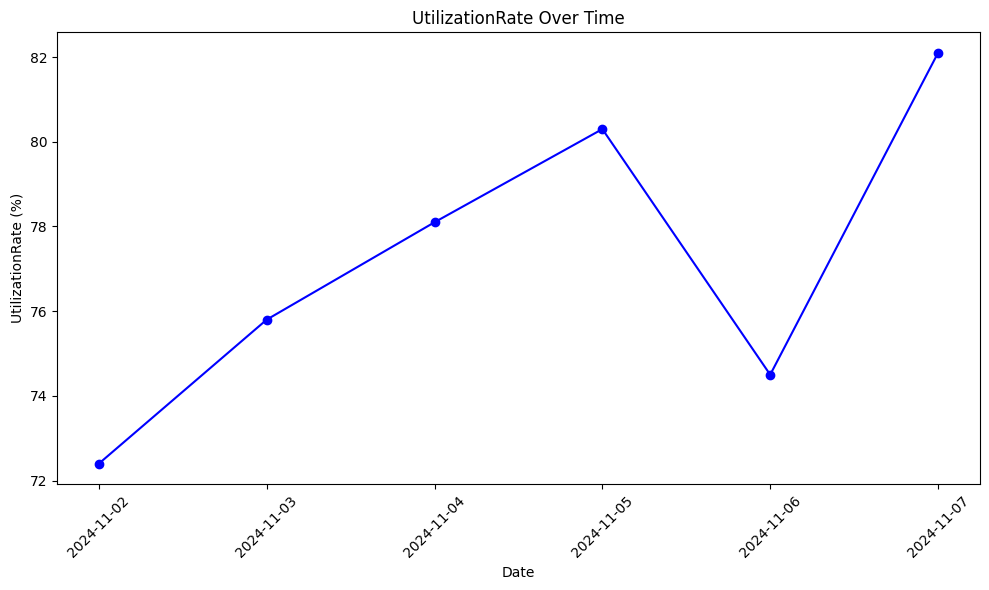



------------



Example 4:
Query: Create a report for the utilization rate for Machine_Z over the past week.
 **Machine_Z Utilization Report for the Past Week**

   - Overall Trends: The utilization rate of Machine_Z has shown a steady increase over the past week, with values ranging from 72.4% on November 2nd to a peak of 82.1% on November 7th. This suggests improved operational efficiency or increased production demands during this period.

   - Anomalies or Outliers: The utilization rate on November 6th (74.5%) appears to be a slight deviation from the overall upward trend, potentially indicating a decrease in productivity or a shift in workload that day.

   - Comparative Analysis: Compared to the initial days of the week, Machine_Z has demonstrated a higher utilization rate towards the end of the week, with an average increase of approximately 4%.

   - Key Performance Metrics: The highest utilization rate was recorded on November 7th (82.1%), while the lowest was on November 2n

In [197]:
examples = [
    # Example 1: Single Value Response
    (
        "What is the average temperature recorded by Sensor_X during October?",
        {
            "machine_name": "Sensor_X",
            "kpi_name": "AverageTemperature",
            "value": 25.3,
            "unit": "°C"
        }
    ),
    # Example 2: Multiple Values Response (Aggregated Data)
    (
        "Provide the weekly production rates for Factory_1 over the past month.",
        {
            "machine_name": "Factory_1",
            "kpi_name": "WeeklyProductionRate",
            "operation": "sum",
            "aggregation": True,
            "values": [
                {"start_date": "2024-11-01", "end_date": "2024-11-07", "value": 1500},
                {"start_date": "2024-11-08", "end_date": "2024-11-14", "value": 1600},
                {"start_date": "2024-11-15", "end_date": "2024-11-21", "value": 1400}
            ],
            "unit": "units"
        }
    ),
    # Example 3: Multiple Values Response (Daily Data)
    (
        "Show a dashboard with the utilization rate for Machine_Z over the past week.",
        {
            "machine_name": "Machine_Z",
            "kpi_name": "UtilizationRate",
            "operation": None,
            "aggregation": None,
            "values": [
                {"date": "2024-11-02", "value": 72.4},
                {"date": "2024-11-03", "value": 75.8},
                {"date": "2024-11-04", "value": 78.1},
                {"date": "2024-11-05", "value": 80.3},
                {"date": "2024-11-06", "value": 74.5},
                {"date": "2024-11-07", "value": 82.1}
            ],
            "unit": "%"
        }
    ),
    # Example 3: Multiple Values Response (Daily Data)
    (
        "Create a report for the utilization rate for Machine_Z over the past week.",
        {
            "machine_name": "Machine_Z",
            "kpi_name": "UtilizationRate",
            "operation": None,
            "aggregation": None,
            "values": [
                {"date": "2024-11-02", "value": 72.4},
                {"date": "2024-11-03", "value": 75.8},
                {"date": "2024-11-04", "value": 78.1},
                {"date": "2024-11-05", "value": 80.3},
                {"date": "2024-11-06", "value": 74.5},
                {"date": "2024-11-07", "value": 82.1}
            ],
            "unit": "%"
        }
    ),
]


# Loop through each example case and generate the response
for index, (query, kpi_response) in enumerate(examples):
    print(f"\nExample {index + 1}:")
    try:
        print(f"Query: {query}")
        definitive_response = response_creation(query, kpi_response)
        print("\n")
        print("-" * 12)
        print("\n")
    except Exception as e:
        print(f"An error occurred: {e}")